In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import os
import time
from scipy import stats
from scipy import constants
from scipy.integrate import odeint
from scipy.optimize import curve_fit



from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import  MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.12.1+cpu


In [2]:
data_h_lhs=pd.read_csv('h_LHS.csv',index_col=False)
# data_h_T_lhs=pd.read_csv('h_T_LHS.csv',index_col=False)
data_lambda_lhs=pd.read_csv('lambda_LHS.csv',index_col=False)
data_T_lhs=pd.read_csv('T_LHS.csv',index_col=False)

data_h_uniform_5000=pd.read_csv('h_uniform_5000.csv',index_col=False)
data_T_uniform_5000=pd.read_csv('T_uniform_5000.csv',index_col=False)


##testing lambda
data_lambda_uniform_5000=pd.read_csv('lambda_uniform_5000.csv',index_col=False)

In [46]:
### Reading values only
h_in=data_h_lhs.values
T_in=data_T_lhs.values
Lambda_in=data_lambda_lhs.values


h_in_notscaled=torch.tensor(h_in).float()
T_in_notscaled=torch.tensor(T_in).float()
Lambda_in_notscaled=torch.tensor(Lambda_in).float()



Lambda_in_test_5000=data_lambda_uniform_5000.values

# Scaling the input and outputs
min_max_scaler_h =MinMaxScaler()
min_max_scaler_T =MinMaxScaler()
min_max_scaler_lambda =MinMaxScaler()

h_scale_in= min_max_scaler_h.fit_transform(h_in)
T_scale_in= min_max_scaler_T.fit_transform(T_in)
Lambda_scale_in= min_max_scaler_lambda.fit_transform(Lambda_in)

## Converting into tensor for nn
h_tensor=torch.Tensor(h_scale_in)[0:3000]
T_tensor=torch.Tensor(T_scale_in)[0:3000]
Lambda_tensor=torch.Tensor(Lambda_scale_in)[0:3000]

# train_test data
h_tensor_2000=torch.Tensor(h_scale_in)[3000:5000]
T_tensor_2000=torch.Tensor(T_scale_in)[3000:5000]
Lambda_tensor_2000=torch.Tensor(Lambda_scale_in)[3000:5000]


##test Data preparation
h_test_in_5000=data_h_uniform_5000.values
T_test_in_5000=data_T_uniform_5000.values
lambda_test_in_5000=data_lambda_uniform_5000.values

min_max_scaler_h_5000 =MinMaxScaler()
min_max_scaler_T_5000 =MinMaxScaler()
min_max_scaler_Lambda_5000=MinMaxScaler()

scale_h_test_in_5000=min_max_scaler_h_5000.fit_transform(h_test_in_5000)
scale_T_test_in_5000=min_max_scaler_T_5000.fit_transform(T_test_in_5000)
scale_Lambda_test_in_5000=min_max_scaler_Lambda_5000.fit_transform(lambda_test_in_5000)

h_tensor_5000=torch.Tensor(scale_h_test_in_5000)
T_tensor_5000=torch.Tensor(scale_T_test_in_5000)
Lambda_tensor_5000=torch.tensor(scale_Lambda_test_in_5000)

# test data
h_in_notscaled_5000=torch.tensor(h_test_in_5000).float()
T_in_notscaled_5000=torch.tensor(T_test_in_5000).float()
lambda_in_notscaled_5000=torch.tensor(lambda_test_in_5000).float()

# zipped_tensor=zip(h_tensor,T_tensor,Lambda_tensor)
# tuple = (h_tensor, T_tensor)
# new_tensor = torch.cat(tuple,-1)
# T = torch.stack((h_tensor,T_tensor), -1)  ## this one is working
# new_tensor

In [14]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)
        self.fc4 = nn.Linear(2, 32)
        self.fc5 = nn.Linear(32, 64)
        self.fc6 = nn.Linear(64, 1)

    def forward(self, h,T):
        
        # tuple_in1 = (h_tensor, T_tensor)
        # in_1 = torch.cat(tuple_in1,-1)
        in_1=torch.concat((h,T),1)
        # in_1 = torch.stack(h,T)
        # in_1=torch.concat(h,T)
        x1 = torch.relu(self.fc1(in_1))
        x2 = torch.relu(self.fc2(x1))
        output_1 = self.fc3(x2)

        # tuple_in2 = (output_1, h_tensor)
        # in_2 = torch.cat(tuple_in2,-1)
        in_2=torch.concat((output_1,h),1)
        # in_2 = torch.stack(output_1,h)
        # in_2=torch.concat(output_1,h)
        x3 = torch.relu(self.fc4(in_2))
        x4 = torch.relu(self.fc5(x3))
        output_2 = self.fc6(x4)
        return output_1,output_2

# Create a model instance from the network
model = Net()
print(model)


Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Linear(in_features=2, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=1, bias=True)
)


In [15]:
loss_criteria=nn.MSELoss()
alpha=1
beta=1
def train(model,h,T,lam,optimizer):
  for i in range(len(h)):
    model.train()
    
    # for i in range(len(h)):
    # optimizer.zero_grad()
    out1,out2=model(h,T)
    loss1=loss_criteria(out1,lam)
    loss2=loss_criteria(out2,T)
    loss=alpha*loss1+beta*loss2
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return loss,out1,out2

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
# validation_loss = []


epochs = 10
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss,lambda_out,T_out = train(model,h_tensor,T_tensor,Lambda_tensor , optimizer)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    print(np.sqrt(train_loss.detach().numpy()))
    # validation_loss.append(test_loss)

Epoch: 1
0.022540288
Epoch: 2
0.021565692
Epoch: 3
0.020597948
Epoch: 4
0.033241954
Epoch: 5
0.050078493
Epoch: 6
0.019390063
Epoch: 7
0.020315388
Epoch: 8
0.019179335
Epoch: 9
0.018852869
Epoch: 10
0.0188079


<function matplotlib.pyplot.show(close=None, block=None)>

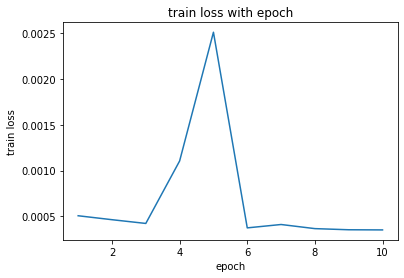

In [21]:
tensor_trainning_loss = torch.tensor(training_loss, requires_grad=False)
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title('train loss with epoch')
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error

In [35]:
prediction_3000=model(h_tensor,T_tensor)


<function matplotlib.pyplot.show(close=None, block=None)>

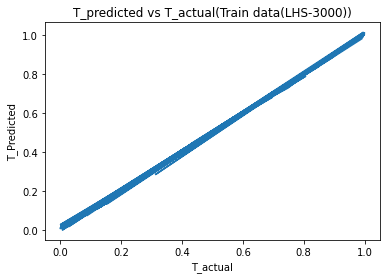

In [70]:
plt.plot(T_tensor,prediction_3000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Train data(LHS-3000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph

In [37]:
prediction_2000=model(h_tensor_2000,T_tensor_2000)

<function matplotlib.pyplot.show(close=None, block=None)>

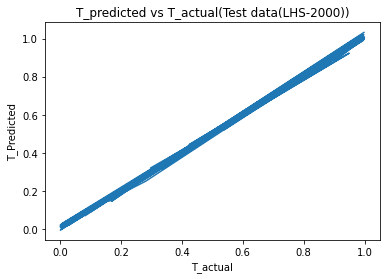

In [67]:
plt.plot(T_tensor_2000,prediction_2000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Test data(LHS-2000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph

<function matplotlib.pyplot.show(close=None, block=None)>

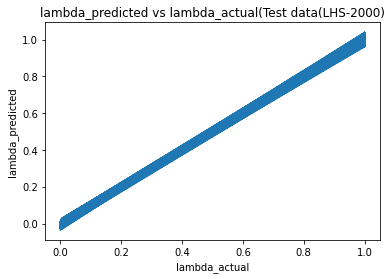

In [74]:
plt.plot(Lambda_tensor_2000,prediction_2000[0].detach().numpy())
plt.xlabel("lambda_actual")
plt.ylabel("lambda_predicted")
plt.title('lambda_predicted vs lambda_actual(Test data(LHS-2000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual

In [39]:
prediction_5000=model(h_tensor_5000,T_tensor_5000)

<function matplotlib.pyplot.show(close=None, block=None)>

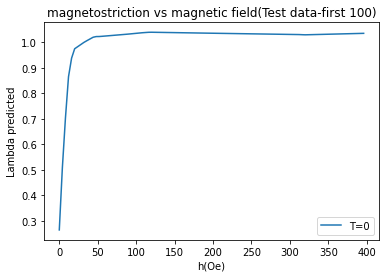

In [77]:
plt.plot(h_test_in_5000[0:100]/79.77,prediction_5000[0][0:100].detach().numpy())
plt.xlabel("h(Oe)")
plt.ylabel("Lambda predicted")
plt.legend(['T=0'])
plt.title('magnetostriction vs magnetic field(Test data-first 100)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

<function matplotlib.pyplot.show(close=None, block=None)>

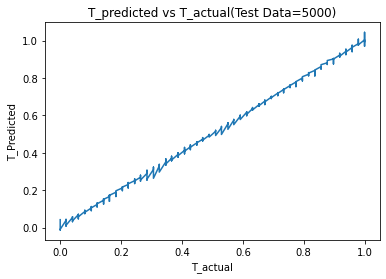

In [71]:
plt.plot(T_tensor_5000,prediction_5000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Test Data=5000)')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph

<function matplotlib.pyplot.show(close=None, block=None)>

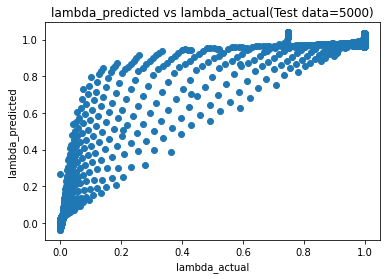

In [76]:
plt.scatter(Lambda_tensor_5000,prediction_5000[0].detach().numpy())
plt.xlabel("lambda_actual")
plt.ylabel("lambda_predicted")
plt.title('lambda_predicted vs lambda_actual(Test data=5000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual

In [49]:
##Saving the model state of 100 epoch

# Additional information
EPOCH = 10
PATH = "model_well.pt"
LOSS = 0.0188079

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [9]:
##Loading model with 100 epoch

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Linear(in_features=2, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=1, bias=True)
)

7.29403357134848

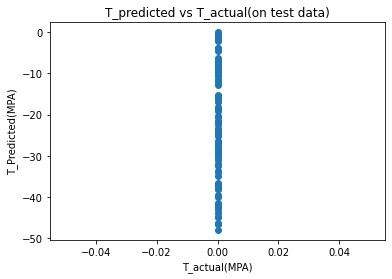

In [18]:
plt.scatter(T_in_notscaled_5000[0:100]/10**6,prediction_5000[1][0:100].detach().numpy()/10**6)
plt.xlabel("T_actual(MPA)")
plt.ylabel("T_Predicted(MPA)")
plt.title('T_predicted vs T_actual(on test data)')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph
mean_squared_error_T=mean_squared_error(T_in_notscaled_5000[0:100],prediction_5000[1][0:100].detach().numpy())
mean_squared_error_T/10**14

In [11]:
## Trainning model for 100 to 110 epochs


learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
# validation_loss = []


epochs = 1000
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss,lambda_out,T_out = train(model,h_in_notscaled,T_in_notscaled,Lambda_in_notscaled , optimizer)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    print(train_loss)
    # validation_loss.append(test_loss)

Epoch: 1
tensor(0.3551, grad_fn=<AddBackward0>)
Epoch: 2
tensor(0.0735, grad_fn=<AddBackward0>)
Epoch: 3
tensor(0.0014, grad_fn=<AddBackward0>)
Epoch: 4
tensor(0.0105, grad_fn=<AddBackward0>)
Epoch: 5
tensor(0.0277, grad_fn=<AddBackward0>)
Epoch: 6
tensor(0.0348, grad_fn=<AddBackward0>)
Epoch: 7
tensor(0.0342, grad_fn=<AddBackward0>)
Epoch: 8
tensor(0.0303, grad_fn=<AddBackward0>)
Epoch: 9
tensor(0.0253, grad_fn=<AddBackward0>)
Epoch: 10
tensor(0.0208, grad_fn=<AddBackward0>)
Epoch: 11
tensor(0.0168, grad_fn=<AddBackward0>)
Epoch: 12
tensor(0.0137, grad_fn=<AddBackward0>)
Epoch: 13
tensor(0.0113, grad_fn=<AddBackward0>)
Epoch: 14
tensor(0.0094, grad_fn=<AddBackward0>)
Epoch: 15
tensor(0.0080, grad_fn=<AddBackward0>)
Epoch: 16
tensor(0.0069, grad_fn=<AddBackward0>)
Epoch: 17
tensor(0.0061, grad_fn=<AddBackward0>)
Epoch: 18
tensor(0.0055, grad_fn=<AddBackward0>)
Epoch: 19
tensor(0.0049, grad_fn=<AddBackward0>)
Epoch: 20
tensor(0.0045, grad_fn=<AddBackward0>)
Epoch: 21
tensor(0.0041, grad

In [12]:
tensor_trainning_loss = torch.tensor(training_loss, requires_grad=False)

<function matplotlib.pyplot.show(close=None, block=None)>

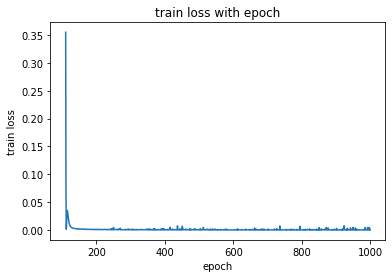

In [13]:
epoch_nums=np.linspace(110,1000,1000)

ax = plt.subplot()
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title('train loss with epoch')
plt.show
# plt.yticks(np.linspace(170,200,10))

## plotting trainning error



In [14]:
prediction_5000_1110=model(h_in_notscaled_5000,T_in_notscaled_5000)

<function matplotlib.pyplot.show(close=None, block=None)>

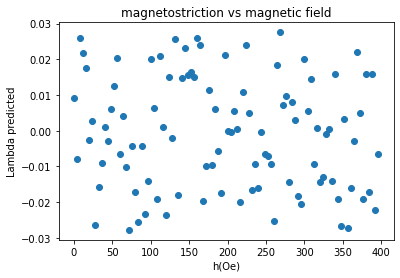

In [15]:
plt.scatter(h_test_in_5000[0:100]/79.77,prediction_5000_1110[0][0:100].detach().numpy())
plt.xlabel("h(Oe)")
plt.ylabel("Lambda predicted")
plt.title('magnetostriction vs magnetic field')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot

<function matplotlib.pyplot.show(close=None, block=None)>

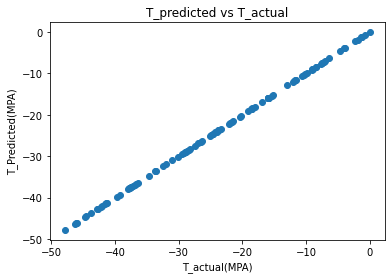

In [16]:
plt.scatter(T_in[0:100]/10**6,prediction_5000_1110[1][0:100].detach().numpy()/10**6)
plt.xlabel("T_actual(MPA)")
plt.ylabel("T_Predicted(MPA)")
plt.title('T_predicted vs T_actual')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph

<function matplotlib.pyplot.show(close=None, block=None)>

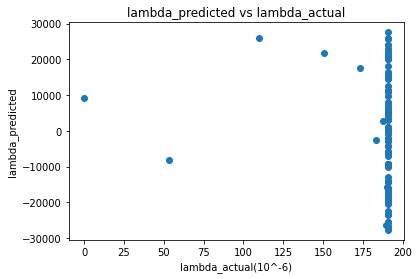

In [18]:
plt.scatter(Lambda_in_test_5000[0:100]*10**6,prediction_5000_1110[0][0:100].detach().numpy()*10**6)
plt.xlabel("lambda_actual(10^-6)")
plt.ylabel("lambda_predicted")
plt.title('lambda_predicted vs lambda_actual')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual

In [19]:
##Saving the model state of 100 epoch

# Additional information
EPOCH = 1110
PATH = "model_1110.pt"
LOSS = 0.0001

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [17]:
##Loading model with 100 epoch
PATH="model.pt"
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Linear(in_features=2, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=1, bias=True)
)

In [18]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0053,  0.3793],
                      [-0.5820, -0.5204],
                      [-0.2723,  0.1896],
                      [-0.0140,  0.5607],
                      [-0.0628,  0.1871],
                      [-0.2137, -0.1390],
                      [-0.6755, -0.4683],
                      [-0.2915,  0.0262],
                      [ 0.2795,  0.4243],
                      [-0.4794, -0.3079],
                      [ 0.2568,  0.5872],
                      [-0.1455,  0.5291],
                      [-0.1140,  0.0748],
                      [ 0.6403, -0.6560],
                      [-0.4452, -0.1790],
                      [-0.2756,  0.6109],
                      [-0.4583, -0.3255],
                      [-0.4940, -0.6622],
                      [-0.4128,  0.6078],
                      [ 0.3155,  0.3427],
                      [ 0.0372, -0.3625],
                      [ 0.1196, -0.6602],
                      [-0.5109, -0.3645],
      